In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

from tqdm import tqdm
import pickle
import h5py

import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u
from astropy import constants as const

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

In [2]:
sys.path.append("..")
from dm21cm.dh_wrappers import TransferFunctionWrapper
from dm21cm.utils import load_h5_dict

In [3]:
wdir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/prod_outputs/elecdecay/Mass0/LightCones'
os.listdir(wdir)

['LightCone_z5.0_HIIDIM=32_BOXLEN=256_fisher_DM_2_r54321.h5',
 'LightCone_z5.0_HIIDIM=32_BOXLEN=256_fisher_DM_1_r54321.h5']

In [11]:
with h5py.File(os.path.join(wdir, 'LightCone_z5.0_HIIDIM=32_BOXLEN=256_fisher_DM_2_r54321.h5'), 'r') as f:
    l = f['lightcones']['brightness_temp'][()]

In [13]:
from py21cmfast import plotting

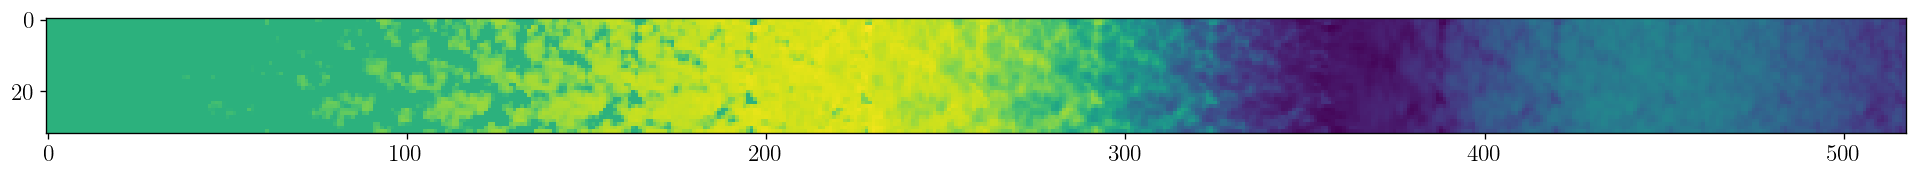

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(l[0,:,:])

AttributeError: 'numpy.ndarray' object has no attribute 'lightcone_dimensions'

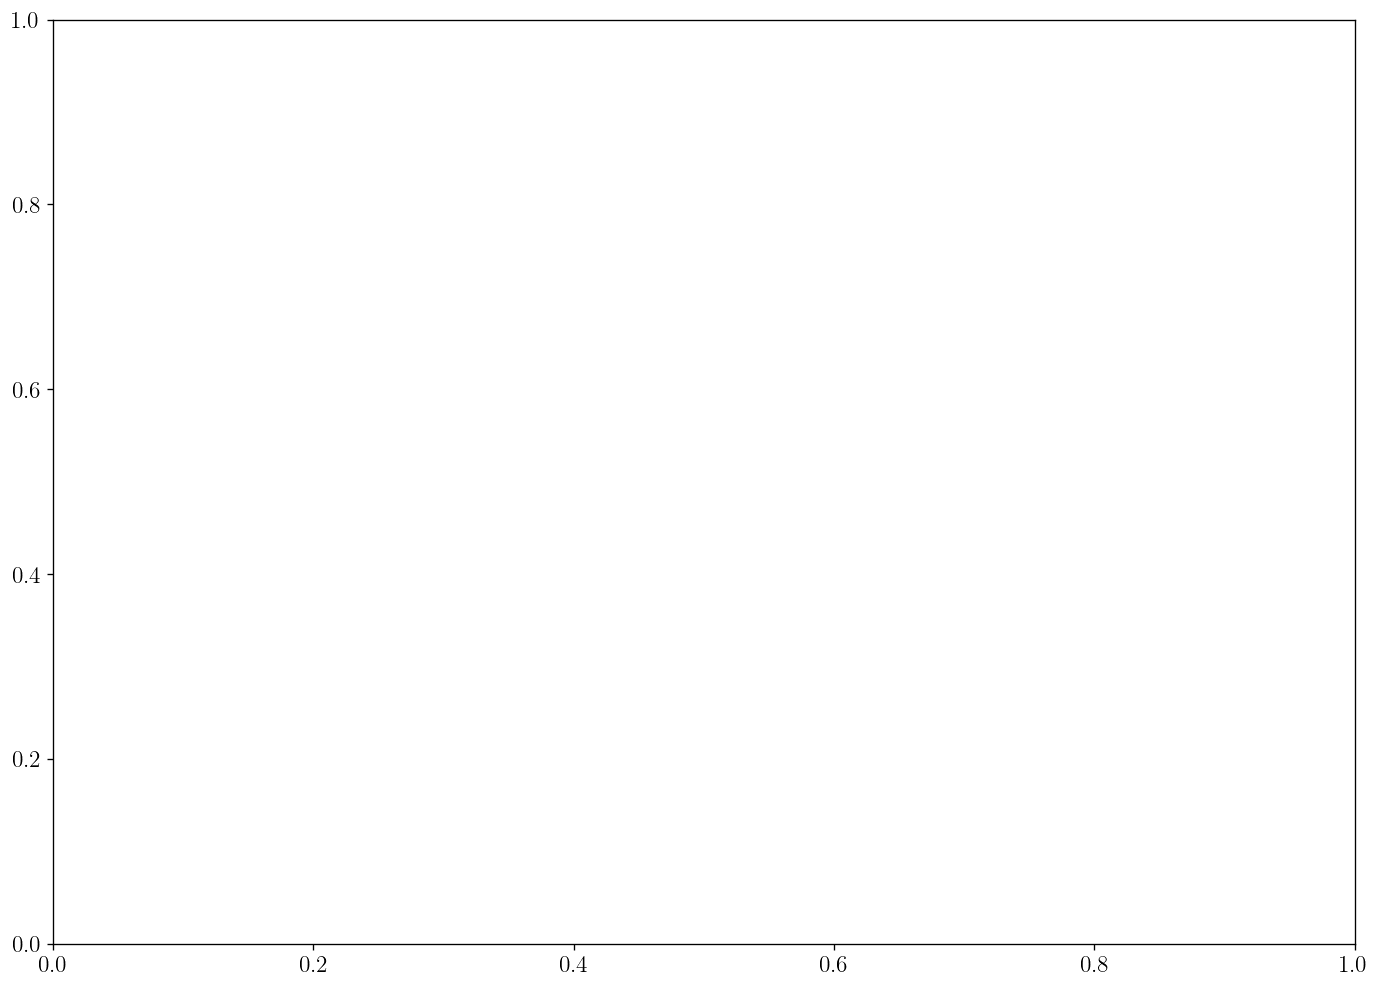

In [14]:
fig, ax = plt.subplots(figsize = (14, 10))
plotting.lightcone_sliceplot(l, fig=fig, ax=ax) 

In [5]:
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/zf01/data'
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
tfw = TransferFunctionWrapper(
    box_dim = 1,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = False,
)

In [6]:
tf = tfw.phot_scat_tf.data[5, :, 6, 6, :]

In [11]:
np.log10(np.min(abscs['photE'])), np.log10(np.max(abscs['photE']))

(-3.983254460526338, 12.728793934188179)

/tmp/ipykernel_1428168/2636896627.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.clip(np.abs(tf), 1e-50, None)), origin='lower', extent=[-3.98,12.72, -3.98,12.72])


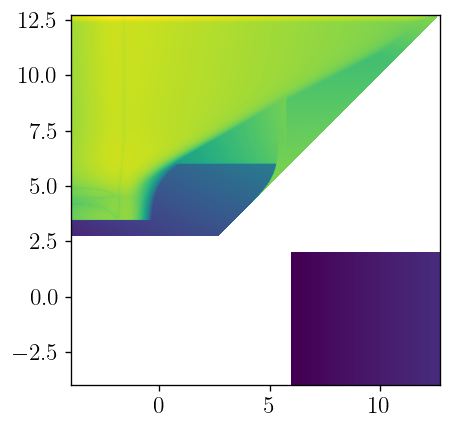

In [12]:
plt.imshow(np.log10(np.clip(np.abs(tf), 1e-50, None)), origin='lower', extent=[-3.98,12.72, -3.98,12.72])